In [2]:
import os

cd = os.getcwd()
print(cd)

/Users/kevinshen/Desktop/Project/ML/animeImageCluster


In [250]:
os.makedirs('proc_imageset', exist_ok = True)
print(os.listdir())

['.DS_Store', 'cat1', 'cat0', 'imageset', '.ipynb_checkpoints', 'imageProcessing.ipynb', 'proc_imageset']


In [5]:
imdir, procdir = os.path.join(cd, 'imageset'), os.path.join(cd, 'proc_imageset')

print(imdir)
print(procdir)

/Users/kevinshen/Desktop/Project/ML/animeImageCluster/imageset
/Users/kevinshen/Desktop/Project/ML/animeImageCluster/proc_imageset


In [6]:
#standardize image (grayscale & fixed size) & store in other folder
std_sz = (50, 50)
from PIL import Image, ImageFilter

In [4]:
#continued... this part, only run once!
loadCount = 0
for file in os.listdir(imdir):
    file_path = os.path.join(imdir, file)
    [nm, ext] = os.path.splitext(file_path)
    
    if ext in ['.jpg', 'jpeg'] and os.stat(file_path).st_size >= 10e3:
        im = Image.open(file_path).resize(std_sz).convert('LA')
        im.save(os.path.join(procdir, str(i)+'.png'), format = 'PNG')
        loadCount += 1
        
print(loadCount)

3620


In [13]:
#run this instead (for 2nd time & more)
loadCount = 3620

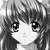

In [7]:
#test if a random image is loaded into 'proc_imageset' folder
from IPython.display import display # to display images
testImPath = os.path.join(procdir, str(3200)+'.png')
testImage = Image.open(testImPath)
display(testImage)


In [10]:
#preview np array structure
import numpy as np
v = np.array(testImage.getdata())
print(v[::400])

[[253 255]
 [220 255]
 [177 255]
 [156 255]
 [183 255]
 [115 255]
 [119 255]]


In [20]:
#load in numpy 
X = np.zeros((loadCount, std_sz[0]*std_sz[1]), dtype = float)

for i in range(loadCount):
    im = Image.open(os.path.join(procdir, str(i)+'.png'))
    X[i] = np.array(im.getdata())[:,0]


In [59]:
#save file, so that you can probably inspect using excel or something. Run once.
np.savetxt('X_data.csv', X, delimiter = ',')

In [21]:
#normalize and train-test split
X = X/255
print(X)

np.random.seed(42)
p = np.random.permutation(loadCount)
cut = int(0.9*loadCount)
trainID = p[:cut]
testID = p[cut:]

trainX = X[trainID]
testX = X[testID]

[[0.99607843 0.99607843 0.99215686 ... 0.13333333 0.6        0.14509804]
 [0.80784314 0.84313725 0.83529412 ... 0.91372549 0.85882353 0.55294118]
 [0.73333333 0.73333333 0.63921569 ... 0.27058824 0.96470588 0.8627451 ]
 ...
 [0.76470588 0.55686275 0.45490196 ... 1.         0.99607843 0.99607843]
 [1.         1.         1.         ... 0.99215686 1.         1.        ]
 [0.82745098 0.83529412 0.79215686 ... 0.90980392 0.90980392 0.90588235]]


In [22]:
#learn 2 categories in training set using KMeans
from sklearn.cluster import KMeans

kmX = KMeans(n_clusters = 2, n_init = 50)
kmX.fit(trainX)
kmLabels = kmX.labels_

In [410]:
#use PCA to reduce feature space dimension, help later visualization
from sklearn.decomposition import PCA
pca = PCA(n_components = 1000)
pca.fit(X)
pcaTrainX = pca.transform(trainX)[:,[0, 1]]
np.shape(pcaTrainX)

(3258, 2)

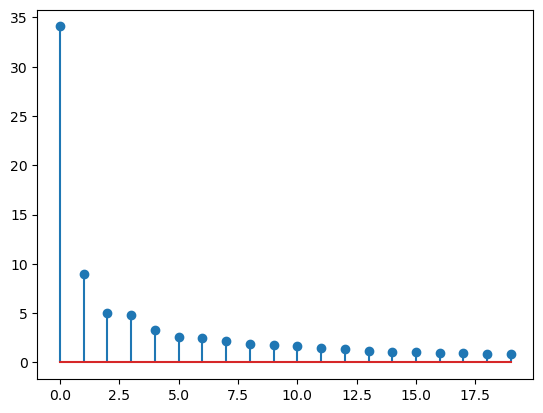

In [411]:
#Principle component eigenvalues: variance stemplot
import matplotlib.pyplot as plt

plt.stem(pca.explained_variance_[:20])
plt.show()

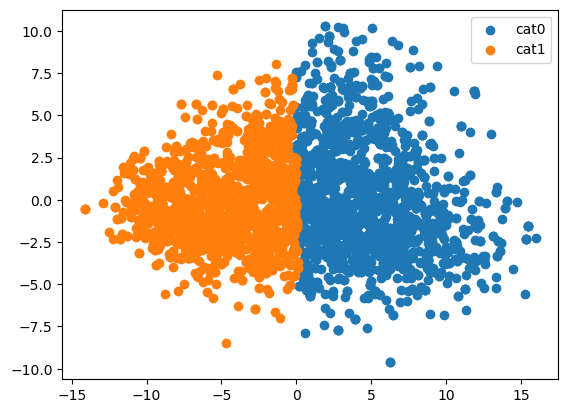

In [412]:
#visualize k-means with leading 2 PCs on cartesian plane

pcaTrain10 = pcaTrainX[kmLabels == 0, 0]
pcaTrain11 = pcaTrainX[kmLabels == 1, 0]

pcaTrain20 = pcaTrainX[kmLabels == 0, 1]
pcaTrain21 = pcaTrainX[kmLabels == 1, 1]

plt.scatter(pcaTrain10, pcaTrain20)
plt.scatter(pcaTrain11, pcaTrain21)
plt.legend(('cat0','cat1'))
plt.show()

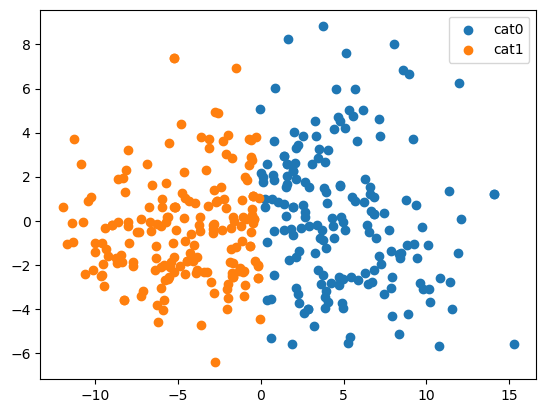

In [413]:
#Check if similar separation exists on validation set.
pcaTestX = pca.transform(testX)[:,[0, 1]]

kmLabelV = kmX.predict(testX)

pcaTest10 = pcaTestX[kmLabelV == 0, 0]
pcaTest11 = pcaTestX[kmLabelV == 1, 0]

pcaTest20 = pcaTestX[kmLabelV == 0, 1]
pcaTest21 = pcaTestX[kmLabelV == 1, 1]

plt.scatter(pcaTest10, pcaTest20)
plt.scatter(pcaTest11, pcaTest21)
plt.legend(('cat0','cat1'))
plt.show()

In [414]:
#Extract the 2 groups in validation set to see what was categorized, in k-means perspective

sampleCat0 = testX[kmLabelV == 0]
sampleCat1 = testX[kmLabelV == 1]

In [415]:
#create folders for result image storage

cat0Path, cat1Path = os.path.join(cd, 'cat0'), os.path.join(cd, 'cat1')

os.makedirs(cat0Path, exist_ok = True)
os.makedirs(cat1Path, exist_ok = True)


In [248]:
#convert np array back to img, store into correct folders
for i in range(len(sampleCat0)):
    test = np.reshape((255*sampleCat0[i]), std_sz)
    im = Image.fromarray(test).convert('LA')
    im.save(os.path.join(cat0Path, str(i)+'.png'), format = 'PNG')
    
for i in range(len(sampleCat1)):
    test = np.reshape((255*sampleCat1[i]), std_sz)
    im = Image.fromarray(test).convert('LA')
    im.save(os.path.join(cat1Path, str(i)+'.png'), format = 'PNG')

### Summary

nothing particularly interesting going on in the splitting. Sort of expected, the kmeans algorithm categorized the image dataset with respect to the relative "brightness" of the images. So what can be seen is dark haired/bg anime faces went into cat0, and brighter images went into cat1.

We can actually do more about the dataset regarding PCA, which is to visualize the eigenfaces and observe how well the faces recover. In particular, maybe we can see which attributes of face each eigenface picks up.

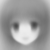

In [416]:
#mean face
display(Image.fromarray(np.uint8(255*np.resize(pca.mean_, std_sz))))

In [417]:
#normalizing function
x = np.array([256, 237, 238])
a = np.minimum(x,255*np.ones((3)))
    
print(a)
    

[255. 237. 238.]


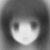

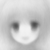

In [418]:
#visualize contribution of eigenface 1:
eigenface1p = np.clip(np.resize(+10*pca.components_[0]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1p)))

eigenface1n = np.clip(np.resize(-10*pca.components_[0]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1n)))

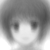

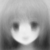

In [419]:
#visualize contribution of eigenface 2:
eigenface1p = np.clip(np.resize(+8*pca.components_[1]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1p)))

eigenface1n = np.clip(np.resize(-8*pca.components_[1]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1n)))

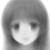

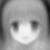

In [420]:
#visualize contribution of eigenface 3:
eigenface1p = np.clip(np.resize(+8*pca.components_[2]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1p)))

eigenface1n = np.clip(np.resize(-8*pca.components_[2]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1n)))

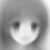

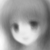

In [421]:
#visualize contribution of eigenface 4:
eigenface1p = np.clip(np.resize(+5*pca.components_[3]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1p)))

eigenface1n = np.clip(np.resize(-5*pca.components_[3]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1n)))

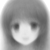

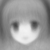

In [422]:
#visualize contribution of eigenface 5:
eigenface1p = np.clip(np.resize(+5*pca.components_[2]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1p)))

eigenface1n = np.clip(np.resize(-5*pca.components_[2]+pca.mean_, std_sz), 0, 1)
display(Image.fromarray(np.uint8(255*eigenface1n)))

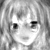

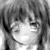

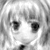

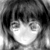

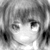

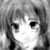

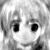

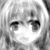

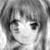

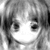

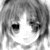

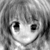

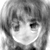

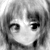

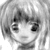

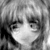

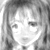

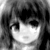

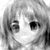

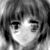

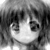

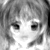

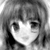

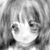

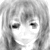

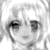

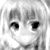

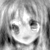

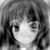

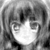

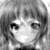

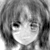

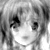

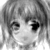

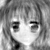

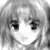

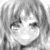

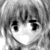

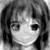

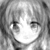

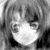

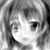

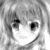

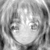

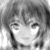

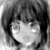

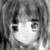

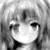

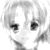

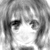

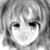

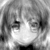

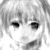

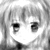

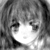

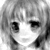

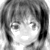

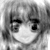

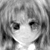

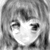

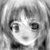

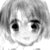

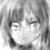

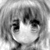

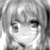

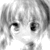

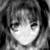

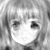

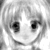

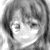

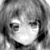

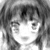

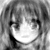

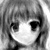

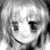

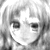

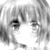

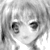

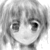

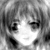

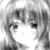

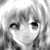

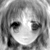

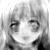

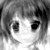

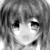

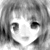

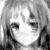

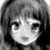

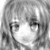

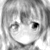

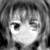

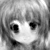

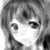

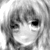

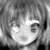

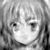

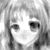

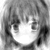

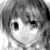

In [446]:
#generate 100 new faces with gaussian dist amt of 1st to n_comp-th eigenfaces
#can tune hyperparameter gamma, exp but recommended is 1, 0.5
n_comp = 200
gamma, exp = 1, 0.5

for i in range(100):
    face_latent = np.random.normal(0,1,size = n_comp)*np.power(pca.explained_variance_[:n_comp]*gamma,exp)
    face_gen = np.clip(np.resize(face_latent @ pca.components_[:n_comp] + pca.mean_, std_sz),0,1)
    display(Image.fromarray(np.uint8(255*face_gen)))